# Training Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

### Read raw training data

In [2]:
amazon = pd.read_csv('/Users/juandherrera/Google Drive/017_Machine Learning/ml/week06/raw_data_train.csv')
print(amazon.shape)

(364000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      325022        259689  259690  B005OTU3HC   A7FAOHXQQ67IG   
1       21947        180669  180670  B000CQBZQK  A1JH5EKCDJPXSH   
2      173768          6184    6185  B000UOFW9K  A1GXDBSMKHB2XV   
3      448516         35144   35145  B002K660S8  A22OXFMANTPGTO   
4      362318        197378  197379  B000084F1I  A2TP6GDF71HM4M   

                     ProfileName  HelpfulnessNumerator  \
0                           Keri                     0   
1        LBDDiaries "LBDDiaries"                     3   
2  Deanna S. Wingart "DeWingart"                     6   
3                        Patrick                     1   
4                           Aera                     1   

   HelpfulnessDenominator  Score        Time                        Summary  \
0                       0      5  1343088000           I LOVE Quinn Popcorn   
1                       4      5  1173312000         Chocolate Hazlenut Tea   
2          

### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [4]:
# vectorize Bag of Words from review text; as sparse matrix
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
X_hv = hv.fit_transform(amazon.Text)
print(X_hv.shape)

/Users/juandherrera/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/Users/juandherrera/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(364000, 131072)


In [5]:
# We want to be able to use this model fit on other data (the test set)
# So let's save a copy of this instance of HashingVectorizer to be able to transform other data with this fit
# http://scikit-learn.org/stable/modules/model_persistence.html
joblib.dump(hv, 'hv.pkl') # pickle

['hv.pkl']

In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
# features from Amazon.csv to add to feature set
# This section needs to stay the same in the train and test section (or figure out a way to reduce redundancies)
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        524
1      5        234
2      3        234
3      3        336
4      5        325
5      3        124
6      5        368
7      5       1685
8      5        199
9      5        576
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 131074)


In [17]:
# look at an example of a "row" of a sparse matrix
print(X_matrix[1234])

  (0, 4412)	0.07609240271492972
  (0, 6236)	0.1257547247137211
  (0, 9622)	0.19402233921859985
  (0, 13677)	0.03906522960328791
  (0, 15207)	0.06530541969978114
  (0, 15498)	0.07035292552925587
  (0, 17096)	0.11756305269393659
  (0, 17417)	0.06989554241303018
  (0, 22965)	0.06422637551290519
  (0, 24190)	0.12489628471112513
  (0, 24734)	0.1239104395563174
  (0, 25170)	0.11496653867553426
  (0, 25311)	0.24624692558021094
  (0, 25458)	0.08345576240468314
  (0, 28983)	0.10878177056432085
  (0, 31028)	0.06478831292809104
  (0, 32242)	0.08321297339961062
  (0, 32615)	0.1903084469103285
  (0, 37241)	0.13197144084322507
  (0, 38528)	0.09445208081038128
  (0, 38990)	0.038178260787708654
  (0, 39989)	0.09476665516184501
  (0, 40190)	0.07784387172457592
  (0, 41490)	0.06510823560789528
  (0, 41642)	0.09017050630346703
  :	:
  (0, 71656)	0.08817097846431819
  (0, 76282)	0.11936807607760733
  (0, 83526)	0.09212283474193285
  (0, 85895)	0.12180517975503341
  (0, 86316)	0.03986026109970078
  (0, 926

### Create `X`, scaled matrix of features

In [18]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_matrix)
print(X.shape)

joblib.dump(sc, 'sc.pkl') # pickle

(364000, 131074)


['sc.pkl']

### create `y`, vector of Labels

In [19]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


# fit models

In [20]:
from my_measures import BinaryClassificationPerformance

### MODEL: ordinary least squares

In [21]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

/Users/juandherrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26613, 'Neg': 337387, 'TP': 13331, 'TN': 165894, 'FP': 171493, 'FN': 13282, 'Accuracy': 0.49237637362637365, 'Precision': 0.07212807860451023, 'Recall': 0.5009206027129598, 'desc': 'ols'}


### MODEL: SVM, linear

In [22]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X, y)
joblib.dump(svm, 'svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 26613, 'Neg': 337387, 'TP': 11407, 'TN': 326379, 'FP': 11008, 'FN': 15206, 'Accuracy': 0.9279835164835165, 'Precision': 0.5089002899843854, 'Recall': 0.4286251080299102, 'desc': 'svm'}


### MODEL: logistic regression

In [23]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
lgs.fit(X, y)
joblib.dump(lgs, 'lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

/Users/juandherrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


{'Pos': 26613, 'Neg': 337387, 'TP': 13540, 'TN': 324152, 'FP': 13235, 'FN': 13073, 'Accuracy': 0.9277252747252748, 'Precision': 0.5056956115779645, 'Recall': 0.5087739074888212, 'desc': 'lgs'}


### MODEL: Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26613, 'Neg': 337387, 'TP': 17149, 'TN': 295893, 'FP': 41494, 'FN': 9464, 'Accuracy': 0.8600054945054945, 'Precision': 0.29243046910969767, 'Recall': 0.644384323450945, 'desc': 'nbs'}


### MODEL: Perceptron

In [25]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X, y)
joblib.dump(prc, 'prc.pkl') # pickle

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

/Users/juandherrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26613, 'Neg': 337387, 'TP': 11912, 'TN': 324484, 'FP': 12903, 'FN': 14701, 'Accuracy': 0.9241648351648352, 'Precision': 0.48003223856538385, 'Recall': 0.4476007966031639, 'desc': 'prc'}


### MODEL: Ridge Regression Classifier

In [26]:
from sklearn import linear_model
# rdg = linear_model.RidgeClassifier(ALL DEFAULTS)
rdg = linear_model.RidgeClassifier()
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 26613, 'Neg': 337387, 'TP': 8054, 'TN': 336773, 'FP': 614, 'FN': 18559, 'Accuracy': 0.9473269230769231, 'Precision': 0.929164743885556, 'Recall': 0.30263405102769325, 'desc': 'rdg'}


### What is the distribution of weights, OLS vs. ridge? 

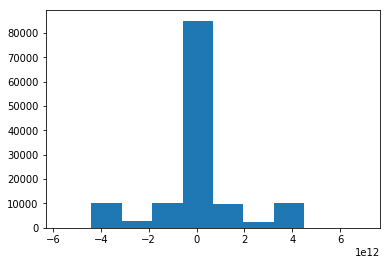

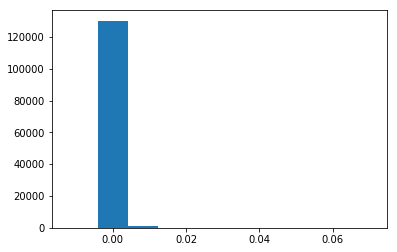

In [27]:
plt.hist(ols.coef_[0])
plt.show()

plt.hist(rdg.coef_[0])
plt.show()

### ROC plot to compare performance of various models and fits

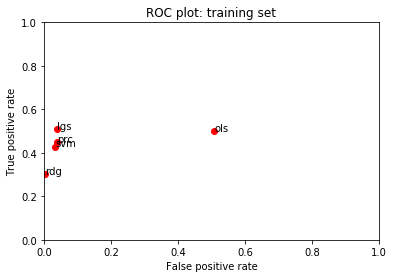

In [28]:
#fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]
fits = [svm_performance, lgs_performance, rdg_performance, prc_performance, ols_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## a digression: looking inside the `rdg` object

[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [ ]:
dir(rdg)

In [29]:
rdg.get_params()

{'alpha': 1.0,
 'class_weight': None,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
type(rdg.coef_)

In [ ]:
rdg.coef_.shape

In [ ]:
print(rdg.coef_[0])

In [ ]:
plt.hist(rdg.coef_[0])
plt.show()